# EDA 5: Statistical testing

Recalculation is needed for get the individual samples

In [8]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [10]:
METRIC_NAME_MAP = {
    'precision': 'Precision@10',
    'recall': 'Recall@10',
    'ndcg': 'NDCG@10',
    'map': 'mAP',
    'mean_median_distance': 'Median distance',
    'gce_users': 'GCE for user fairness',
    'precision_active_users': 'Precision@10 (active users)',
    'precision_inactive_users': 'Precision@10 (inactive users)',
    'gce_items': 'GCE for item fairness',
    'exposure_short_head': 'Exposure count (short-head POIs)',
    'exposure_long_tail': 'Exposure count (long-tail POIs)',
}

dataset_sizes = {
    'Yelp': 7135,
    'Gowalla': 5628
}

## 1. Loading the data

In [42]:
def get_reclist_filename(experiment, model_name, dataset, exposure_model='Linear', provider_factor=0, consumer_factor=0, printfn=False):
    fairness = 'None'
    filename = f"../Outputs/{exposure_model}Fairness/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"

    # loading exposure model
    if experiment == 'exposure_model':
        if provider_factor in [0.25, 0.75]:
            fairness = f'Provider_{exposure_model}Exposure_alpha' + str(provider_factor)
            filename = f"../Outputs/1_ExposureModelComparison/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.txt"
        elif provider_factor in [0.5, 1.0]:
            fairness = 'Provider' + str(provider_factor)
            filename = f"../Outputs/{exposure_model}Fairness/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"
    elif experiment == 'provider':
        if provider_factor > 0:
            fairness = 'Provider' + str(provider_factor)
            filename = f"../Outputs/LinearFairness/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"
    elif experiment == 'consumer':
        if consumer_factor > 0:
            fairness = 'Consumer_beta' + str(consumer_factor)
            filename = f"../Outputs/3_ConsumerBeta/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.txt"
    elif experiment == 'both':
        if consumer_factor == 0:
            fairness = 'Provider1.0'
            filename = f"../Outputs/LinearFairness/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"
        elif consumer_factor == 1.0:
            fairness = 'Consumer_beta' + str(consumer_factor)
            filename = f"../Outputs/3_ConsumerBeta/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.txt"
        else:
            fairness = f'Both_LinearExposure_alpha{provider_factor}_beta{consumer_factor}'
            filename = f"../Outputs/4_Tradeoff/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit30.txt"

    if printfn:
        print(f"Loading {filename}...")
    return filename

def load_reclists(experiment, model_name, dataset, exposure_model='Linear', provider_factor=0, consumer_factor=0):
    filename = get_reclist_filename(experiment, model_name, dataset, exposure_model, provider_factor, consumer_factor)
    reclists = {}
    reclist_data = open(filename, 'r').readlines()
    for line in reclist_data:
        _, user_id, reclist = line.strip().split('\t')
        reclist = list(int(x) for x in reclist.split(','))
        reclists[int(user_id)] = reclist

    return reclists

In [157]:
from Data.loadDatasetFiles import loadDatasetFiles
from Data.readDataSizes import readDataSizes
from Models.utils import readTrainingData, readTestData

datasetName = 'Gowalla'

datasetFiles = loadDatasetFiles(datasetName)
dataDictionary = readDataSizes(datasetName, datasetFiles)
users, pois = dataDictionary['users'], dataDictionary['pois']
trainingMatrix, userCheckinCounts, poiCheckinCounts = readTrainingData(datasetFiles['train'], users['count'], pois['count'], False)
groundTruth = readTestData(datasetFiles['test'])

Loading Gowalla dataset files ...
Gowalla dataset files have been loaded for processing!
Reading the 'dataSize' file to prepare further processing...
Gowalla dataset contains 5628 users, 31803 locations, and 0 categories!
Reading training data...
Setting threshold to median repeating POI ratio of 0.3
Setting threshold to 80th prc. of POI visits of 18.0
Reading test data...


In [158]:
longtailPois = set(poiCheckinCounts[~poiCheckinCounts.short_head].index)

In [159]:
groundTruth[3535]

{39, 2625, 3400, 6776, 8379, 9242, 11788, 13382}

## 2. Generating the metric samples

In [160]:
from Evaluations.metrics.accuracy import precisionk
from Evaluations.metrics.fairness import exposureMetricByItemGroup
from collections import Counter

# per-user

def precisionk_samples(reclists):
    return np.array([precisionk(groundTruth[uid], reclists[uid] if uid in reclists else []) for uid in range(users['count'])])

# per-poi

def longtail_exposure_samples(reclists):
    # generate exposure map
    exposure_map = Counter([r for uid, reclist in reclists.items() for r in reclist])
    return np.array([exposure_map[p] if p in exposure_map else 0 for p in range(pois['count']) if p in longtailPois])

In [161]:
_tmp = load_reclists('exposure_model', 'LORE', datasetName, exposure_model='PowerLaw', provider_factor=0.25)
# _tmp = load_reclists('provider', 'USG', 'Gowalla', provider_factor=0.8)
# _tmp = load_reclists('consumer', 'GeoSoCa', 'Yelp', consumer_factor=0.6)
# _tmp = load_reclists('both', 'LORE', 'Yelp', consumer_factor=0.25, provider_factor=0.25)
_tmp[3535]

[17159, 27287, 14937, 15137, 17149, 14900, 1890, 456, 11743, 1609]

In [162]:
precisionk_samples(_tmp).shape

(5628,)

In [163]:
longtail_exposure_samples(_tmp).shape

(24700,)

## 4. Does Exposure model have an impact?

In [120]:
from scipy.stats import kruskal

def is_significant(pvalue):
    if pvalue < 0.05:
        return "p < 0.05, reject the null hypothesis"
    else:
        return "p >= 0.05, don\'t reject the null hypothesis"

def test_exposure_models(model, dataset, provider_factor):
    linear_em = load_reclists('exposure_model', model, dataset, exposure_model='Linear', provider_factor=provider_factor)
    powerlaw_em = load_reclists('exposure_model', model, dataset, exposure_model='PowerLaw', provider_factor=provider_factor)
    logistic_em = load_reclists('exposure_model', model, dataset, exposure_model='Logistic', provider_factor=provider_factor)

    linear_prec = precisionk_samples(linear_em)
    powerlaw_prec = precisionk_samples(powerlaw_em)
    logistic_prec = precisionk_samples(logistic_em)
    
    linear_longtail = longtail_exposure_samples(linear_em)
    powerlaw_longtail = longtail_exposure_samples(powerlaw_em)
    logistic_longtail = longtail_exposure_samples(logistic_em)

    prec_test = kruskal(linear_prec, powerlaw_prec, logistic_prec)
    longtail_test = kruskal(linear_longtail, powerlaw_longtail, logistic_longtail)

    print(f"Avg. precision@k: {linear_prec.mean():.4f} vs {logistic_prec.mean():.4f} vs {powerlaw_prec.mean():.4f}")
    print(f"Precision: H={prec_test.statistic:.3f}, p={prec_test.pvalue:.3f}")
    print(is_significant(prec_test.pvalue))
    print("")
    print(f"Avg. longtail exposure: {linear_longtail.mean():.4f} vs {logistic_longtail.mean():.4f} vs {powerlaw_longtail.mean():.4f}")
    print(f"Long-tail exposure: H={longtail_test.statistic:.3f}, p={longtail_test.pvalue:.3f}")
    print(is_significant(longtail_test.pvalue))

### Yelp

**provider factor weight = 0.25**

In [121]:
test_exposure_models('GeoSoCa', 'Yelp', 0.25)

Avg. precision@k: 0.0134 vs 0.0173 vs 0.0137
Precision: H=30.337, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 3.4467 vs 3.0696 vs 3.1636
Long-tail exposure: H=786.792, p=0.000
p < 0.05, reject the null hypothesis


In [122]:
test_exposure_models('LORE', 'Yelp', 0.25)

Avg. precision@k: 0.0179 vs 0.0183 vs 0.0196
Precision: H=4.798, p=0.091
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 2.7975 vs 3.4217 vs 2.2284
Long-tail exposure: H=1185.228, p=0.000
p < 0.05, reject the null hypothesis


In [123]:
test_exposure_models('USG', 'Yelp', 0.25)

Avg. precision@k: 0.0314 vs 0.0296 vs 0.0300
Precision: H=2.242, p=0.326
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 0.0341 vs 0.0461 vs 0.0209
Long-tail exposure: H=47.392, p=0.000
p < 0.05, reject the null hypothesis


**provider factor weight = 0.5**

In [124]:
test_exposure_models('GeoSoCa', 'Yelp', 0.5)

Avg. precision@k: 0.0117 vs 0.0089 vs 0.0109
Precision: H=26.840, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 4.1525 vs 4.5693 vs 3.5278
Long-tail exposure: H=2607.133, p=0.000
p < 0.05, reject the null hypothesis


In [125]:
test_exposure_models('LORE', 'Yelp', 0.5)

Avg. precision@k: 0.0147 vs 0.0096 vs 0.0136
Precision: H=69.317, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 3.6141 vs 4.8180 vs 2.1647
Long-tail exposure: H=4504.831, p=0.000
p < 0.05, reject the null hypothesis


In [126]:
test_exposure_models('USG', 'Yelp', 0.5)

Avg. precision@k: 0.0278 vs 0.0257 vs 0.0291
Precision: H=11.141, p=0.004
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.5424 vs 1.1532 vs 0.2791
Long-tail exposure: H=1405.522, p=0.000
p < 0.05, reject the null hypothesis


### Gowalla

**provider factor weight = 0.25**

In [76]:
test_exposure_models('GeoSoCa', 'Gowalla', 0.25)

Avg. precision@k: 0.0300 vs 0.0316 vs 0.0276
Precision: H=20.016, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=1016.396, p=0.000
p < 0.05, reject the null hypothesis


In [77]:
test_exposure_models('LORE', 'Gowalla', 0.25)

Avg. precision@k: 0.0427 vs 0.0283 vs 0.0392
Precision: H=112.076, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=5297.219, p=0.000
p < 0.05, reject the null hypothesis


In [78]:
test_exposure_models('USG', 'Gowalla', 0.25)

Avg. precision@k: 0.0504 vs 0.0500 vs 0.0525
Precision: H=4.364, p=0.113
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=54.929, p=0.000
p < 0.05, reject the null hypothesis


**provider factor weight = 0.5**

In [79]:
test_exposure_models('GeoSoCa', 'Gowalla', 0.5)

Avg. precision@k: 0.0287 vs 0.0182 vs 0.0242
Precision: H=80.919, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=8742.328, p=0.000
p < 0.05, reject the null hypothesis


In [80]:
test_exposure_models('LORE', 'Gowalla', 0.5)

Avg. precision@k: 0.0405 vs 0.0149 vs 0.0260
Precision: H=489.789, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=13453.235, p=0.000
p < 0.05, reject the null hypothesis


In [81]:
test_exposure_models('USG', 'Gowalla', 0.5)

Avg. precision@k: 0.0477 vs 0.0334 vs 0.0468
Precision: H=89.044, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7696 vs 1.7696 vs 1.7696
Long-tail exposure: H=694.806, p=0.000
p < 0.05, reject the null hypothesis


## 5. Does provider factor have a significant increase in long-tail exposure, without a significant decrease in precision?

<Axes: ylabel='Count'>

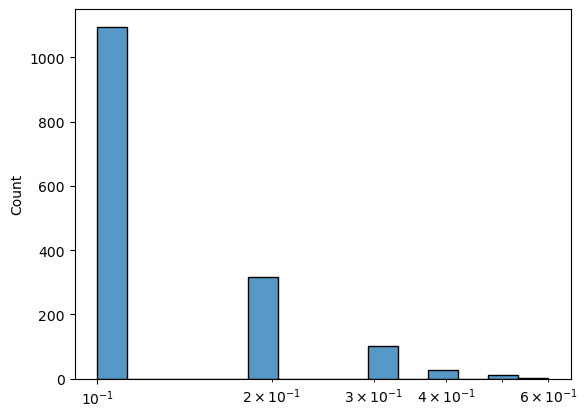

In [90]:
sns.histplot(precisionk_samples(_tmp), log_scale=True)

<Axes: ylabel='Count'>

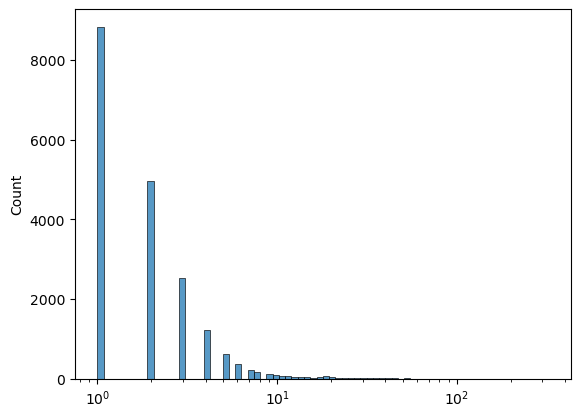

In [92]:
sns.histplot(longtail_exposure_samples(_tmp), log_scale=True)

not lognormal...

In [127]:
from scipy.stats import wilcoxon

def test_provider_factor(model, dataset, provider_factor):
    before_pf = load_reclists('provider', model, dataset, exposure_model='Linear', provider_factor=0)
    after_pf = load_reclists('provider', model, dataset, exposure_model='Linear', provider_factor=provider_factor)

    before_prec = precisionk_samples(before_pf)
    after_prec = precisionk_samples(after_pf)
    before_longtail = longtail_exposure_samples(before_pf)
    after_longtail = longtail_exposure_samples(after_pf)

    prec_test = wilcoxon(before_prec, after_prec)
    longtail_test = wilcoxon(before_longtail, after_longtail)

    print(f"Avg. precision@k: {before_prec.mean():.4f} vs {after_prec.mean():.4f}")
    print(f"Precision: H={prec_test.statistic:.3f}, p={prec_test.pvalue:.3f}")
    print(is_significant(prec_test.pvalue))
    print("")
    print(f"Avg. longtail exposure: {before_longtail.mean():.4f} vs {after_longtail.mean():.4f}")
    print(f"Long-tail exposure: H={longtail_test.statistic:.3f}, p={longtail_test.pvalue:.3f}")
    print(is_significant(longtail_test.pvalue))

### Yelp

**provider factor weight = 0.1**

ideally no impact

In [128]:
test_provider_factor('GeoSoCa', 'Yelp', 0.1)

Avg. precision@k: 0.0225 vs 0.0168
Precision: H=51192.500, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7010 vs 2.6597
Long-tail exposure: H=436717.000, p=0.000
p < 0.05, reject the null hypothesis


In [129]:
test_provider_factor('LORE', 'Yelp', 0.1)

Avg. precision@k: 0.0230 vs 0.0208
Precision: H=30149.000, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.5290 vs 2.1453
Long-tail exposure: H=332956.000, p=0.000
p < 0.05, reject the null hypothesis


In [130]:
test_provider_factor('USG', 'Yelp', 0.1)

Avg. precision@k: 0.0297 vs 0.0304
Precision: H=14508.500, p=0.006
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.0077 vs 0.0116
Long-tail exposure: H=0.000, p=0.000
p < 0.05, reject the null hypothesis


### Gowalla

**provider factor weight = 0.1**

ideally no impact

In [138]:
test_provider_factor('GeoSoCa', 'Gowalla', 0.1)

Avg. precision@k: 0.0381 vs 0.0321
Precision: H=34104.000, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.7990 vs 0.9167
Long-tail exposure: H=8188097.000, p=0.000
p < 0.05, reject the null hypothesis


In [139]:
test_provider_factor('LORE', 'Gowalla', 0.1)

Avg. precision@k: 0.0482 vs 0.0451
Precision: H=21580.000, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.7354 vs 0.8338
Long-tail exposure: H=137338.500, p=0.000
p < 0.05, reject the null hypothesis


In [140]:
test_provider_factor('USG', 'Gowalla', 0.1)

Avg. precision@k: 0.0514 vs 0.0522
Precision: H=36895.000, p=0.114
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 0.0766 vs 0.0864
Long-tail exposure: H=8003.000, p=0.000
p < 0.05, reject the null hypothesis


oh well

## 6. Does consumer factor have a significant increase in precision?

In [164]:
from scipy.stats import wilcoxon

def test_consumer_factor(model, dataset, consumer_factor):
    before_cf = load_reclists('consumer', model, dataset, exposure_model='Linear', consumer_factor=0)
    after_cf = load_reclists('consumer', model, dataset, exposure_model='Linear', consumer_factor=consumer_factor)

    before_prec = precisionk_samples(before_cf)
    after_prec = precisionk_samples(after_cf)
    before_longtail = longtail_exposure_samples(before_cf)
    after_longtail = longtail_exposure_samples(after_cf)

    prec_test = wilcoxon(before_prec, after_prec)
    longtail_test = wilcoxon(before_longtail, after_longtail)

    print(f"Avg. precision@k: {before_prec.mean():.4f} vs {after_prec.mean():.4f}")
    print(f"Precision: H={prec_test.statistic:.3f}, p={prec_test.pvalue:.3f}")
    print(is_significant(prec_test.pvalue))
    print("")
    print(f"Avg. longtail exposure: {before_longtail.mean():.4f} vs {after_longtail.mean():.4f}")
    print(f"Long-tail exposure: H={longtail_test.statistic:.3f}, p={longtail_test.pvalue:.3f}")
    print(is_significant(longtail_test.pvalue))

### Yelp

**consumer factor weight = 0.1**

ideally positive impact

In [151]:
test_consumer_factor('GeoSoCa', 'Yelp', 0.1)

Avg. precision@k: 0.0225 vs 0.0242
Precision: H=18485.000, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.7010 vs 0.8583
Long-tail exposure: H=337879.500, p=0.000
p < 0.05, reject the null hypothesis


In [152]:
test_consumer_factor('LORE', 'Yelp', 0.1)

Avg. precision@k: 0.0230 vs 0.0235
Precision: H=6337.000, p=0.005
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 1.5290 vs 1.1384
Long-tail exposure: H=245499.500, p=0.000
p < 0.05, reject the null hypothesis


In [153]:
test_consumer_factor('USG', 'Yelp', 0.1)

Avg. precision@k: 0.0297 vs 0.0295
Precision: H=294.000, p=0.133
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 0.0077 vs 0.0058
Long-tail exposure: H=27.000, p=0.000
p < 0.05, reject the null hypothesis


### Gowalla

In [165]:
test_consumer_factor('GeoSoCa', 'Gowalla', 0.1)

Avg. precision@k: 0.0381 vs 0.0422
Precision: H=28869.500, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.7990 vs 0.4862
Long-tail exposure: H=1925681.500, p=0.000
p < 0.05, reject the null hypothesis


In [166]:
test_consumer_factor('LORE', 'Gowalla', 0.1)

Avg. precision@k: 0.0482 vs 0.0492
Precision: H=14675.500, p=0.000
p < 0.05, reject the null hypothesis

Avg. longtail exposure: 0.7354 vs 0.5957
Long-tail exposure: H=407984.000, p=0.000
p < 0.05, reject the null hypothesis


In [167]:
test_consumer_factor('USG', 'Gowalla', 0.1)

Avg. precision@k: 0.0514 vs 0.0514
Precision: H=4106.000, p=0.955
p >= 0.05, don't reject the null hypothesis

Avg. longtail exposure: 0.0766 vs 0.0677
Long-tail exposure: H=1908.000, p=0.000
p < 0.05, reject the null hypothesis


## 7. Can a tradeoff achieve significant improvements in both?

In [164]:
from scipy.stats import wilcoxon

def test_consumer_factor(model, dataset, consumer_factor):
    before_cf = load_reclists('consumer', model, dataset, exposure_model='Linear', consumer_factor=0)
    after_cf = load_reclists('consumer', model, dataset, exposure_model='Linear', consumer_factor=consumer_factor)

    before_prec = precisionk_samples(before_cf)
    after_prec = precisionk_samples(after_cf)
    before_longtail = longtail_exposure_samples(before_cf)
    after_longtail = longtail_exposure_samples(after_cf)

    prec_test = wilcoxon(before_prec, after_prec)
    longtail_test = wilcoxon(before_longtail, after_longtail)

    print(f"Avg. precision@k: {before_prec.mean():.4f} vs {after_prec.mean():.4f}")
    print(f"Precision: H={prec_test.statistic:.3f}, p={prec_test.pvalue:.3f}")
    print(is_significant(prec_test.pvalue))
    print("")
    print(f"Avg. longtail exposure: {before_longtail.mean():.4f} vs {after_longtail.mean():.4f}")
    print(f"Long-tail exposure: H={longtail_test.statistic:.3f}, p={longtail_test.pvalue:.3f}")
    print(is_significant(longtail_test.pvalue))